In [1]:
import sys, os

# Si es necesaria la instalación de paquetes
if False:
    os.system('pip install geopandas')
    os.system('pip install contextily')
    os.system('pip install dipy')


#set up psycopg2 environment
import psycopg2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

#--> conda install contextily --channel conda-forge
import contextily as ctx
import geopy.distance


from shapely.geometry import LineString
from pyproj import Proj, transform


#------------------------------------------------------------------------------------
# Required by clustering class QuickBundles
#------------------------------------------------------------------------------------
import dipy 
from dipy.segment.metric import Metric
#from dipy.segment.metric import ResampleFeature
from dipy.segment.clustering import QuickBundles
#------------------------------------------------------------------------------------


La siguiente clase es utilizada como parámetro por el algoritmo Quickbundles. Es una herencia de la clase Metric, la que se utiliza para medir "el parecido" entre dos trayectos.

Más información en dipy.org: [1](https://dipy.org/documentation/1.0.0./examples_built/segment_quickbundles/) y [2](https://dipy.org/documentation/1.1.1./examples_built/segment_clustering_features/)


Incluye:

1. Un conversor (ResampleFeature) que hace que los trayectos tengan exactamente 256 puntos. Se ejecuta al crear el objeto Metric sobre todos los argumentos (v1 y v2)

2. Una medida de compatibilidad de los argumentos
3. Un método para clacular la distancia

In [2]:
class GPSDistance(Metric):
    def __init__(self):
        super().__init__(feature=dipy.segment.featurespeed.ResampleFeature(nb_points=256))
        #self._geod = Geod(ellps='WGS84')

    def are_compatible(self, shape_1, shape_2):
        return len(shape_1) == len(shape_2)
    def dist(self, v1, v2):
        distances = [geopy.distance.distance([p[0][0],p[0][1]],[p[1][0],p[1][1]]).km for p in list(zip(v1,v2))]
        return np.mean(distances)/1000.0

EL siguiente método agrega un mapa OSM de fondo a un gráfico, mediante la librería Contextily
https://contextily.readthedocs.io/en/latest/

Más información de mapas teselados en esta página
https://sgtmapabaseigo.github.io/MapaBaseIGO/referencias/mapas_teselados/

In [3]:
#------------------------------------------------------------------------------------
#   Base map (OpenStretMap) for visualisation
#------------------------------------------------------------------------------------
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/{z}/{x}/{y}.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, source=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

Step1: Stablish connection between python and postgresql and get some tracks (result)

In [4]:
import warnings
warnings.filterwarnings('ignore')
conn = psycopg2.connect("dbname = 'mlearn' user = 'ml_aa00' host = 'obd.ac.uma.es' password = 'vc0910$$'")
#cur = conn.cursor()
sql="select * from pract3_trim where not st_isempty(tripline);"
#cur.execute(sql)
#result = cur.fetchone()
#cur.close()
result = gpd.GeoDataFrame.from_postgis(sql, conn, geom_col='tripline', crs  ={'init': 'epsg:4326'} )#.to_crs(epsg=3857)
conn.close()
result

,idtrip,tripline,distance,length,numsamples
0,718,"LINESTRING (-4.45526 36.71362, -4.45526 36.713...",14373.610674,1641.364738,142
1,506,"LINESTRING (-4.47384 36.71488, -4.47381 36.714...",4887.678097,1826.994243,138
2,624,"LINESTRING (-4.46760 36.71295, -4.46706 36.712...",4156.704673,1119.924500,32
3,410,"LINESTRING (-4.45935 36.71115, -4.45921 36.711...",3517.427327,472.625104,33
4,673,"LINESTRING (-4.46955 36.71315, -4.46949 36.713...",5511.646364,1788.754948,123
...,...,...,...,...,...
154,921,"LINESTRING (-4.48291 36.71749, -4.48299 36.717...",6001.925315,2953.314172,213
155,892,"LINESTRING (-4.48276 36.71735, -4.48290 36.717...",6014.206985,2961.997056,139
156,893,"LINESTRING (-4.45526 36.71360, -4.45547 36.713...",5849.581742,2851.686271,126
157,926,"LINESTRING (-4.45526 36.71359, -4.45526 36.713...",5868.614484,2883.594633,132


Create the canvas for plotting

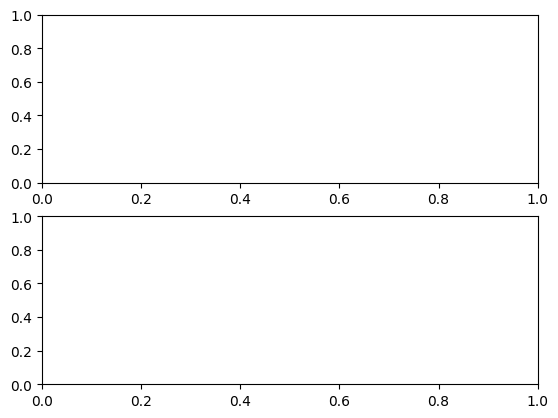

In [5]:
#plt.ion() #interactive... continue after plot
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#base = world.plot(color='white', edgecolor='black')
#ax=result.plot(ax=base)
fig = plt.figure() # 
ax1 = plt.subplot(2,1,1) 
ax2 = plt.subplot(2,1,2, sharex = ax1, sharey = ax1)

Step 2: Store tracks in a custon array, before using QuickBundles

In [8]:
result=result['tripline']
result3857=result.to_crs(epsg=3857)
result3857.plot(ax=ax1)
add_basemap(ax1, zoom=15)
print(result.head())
listarray = []
#from shapely.ops import linemerge
for track in result:
    if track.geom_type == 'LineString':
        x,y = track.coords.xy
        listarray.append(np.transpose([x,y]))

0    LINESTRING (-4.45526 36.71362, -4.45526 36.713...
1    LINESTRING (-4.47384 36.71488, -4.47381 36.714...
2    LINESTRING (-4.46760 36.71295, -4.46706 36.712...
3    LINESTRING (-4.45935 36.71115, -4.45921 36.711...
4    LINESTRING (-4.46955 36.71315, -4.46949 36.713...
Name: tripline, dtype: geometry


<Figure size 640x480 with 0 Axes>

Step 3: Execute QuickBundles

In [9]:
print('Iniciando algoritmo')
metric=GPSDistance()
qb=QuickBundles(threshold=0.001,metric=metric)

Iniciando algoritmo


In [10]:
clusters=qb.cluster(listarray)
print('Numero de clusters, ',len(clusters))

Numero de clusters,  7


Step 4: Read clusters from results and draw on map

In [11]:
outProj = Proj(init='epsg:3857')
inProj = Proj(init='epsg:4326')
color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
cnt=0
for i in range(0,len(clusters)):
    if len(clusters[i].indices) > 2:
        cnt=cnt+1
        for j in clusters[i].indices:
            lista=listarray[j]
            line =LineString(lista)
            x,y=transform(inProj,outProj,line.coords.xy[0],line.coords.xy[1])
            ax2.plot(x,y,color[i%8])
print("Tengo" ,cnt, " clusters validos")
add_basemap(ax2, zoom=15)
plt.show()

Tengo 5  clusters validos
